In [36]:
import numpy as np
import xgboost as xgb
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBT
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import pytz
import pickle
import matplotlib as plt
%matplotlib inline

#from sklearn.preprocessing import CategoricalEncoder
#CategoricalEncoder is part of sklearn's developer version, which you can't just update with conda. If you have issues
#getting this version, try a hard code implementation of the library here - https://pastebin.com/qs1es9XE

In [3]:
#reads a weird json, and returns the bids dataframe and ads dataframe
def read_weird_json(path):
    bids = []
    ads = []

    with open(path) as f:
        for line in f:
            line_dict = json.loads(line.encode('utf-8'))
            if 'advertiser_id' in line_dict:
                if line_dict['rate_metric'] != 'CPC':
                    continue
                ads.append(line_dict)
            else:
                bids.append(line_dict)
    df_bids = pd.DataFrame.from_records(bids)
    df_ads = pd.DataFrame.from_records(ads)  
    
    return [df_bids, df_ads]

#Returns a list of dataframes. Only looks at ads. 
def read_many_jsons(paths): 
    dfs = []
    for path in paths: 
        dfs += [read_weird_json(path)[1]]
    return dfs

## Load in the data for the training set

In [4]:
#Open our hdf files
neg2 = pd.HDFStore('./data/day2_negatives_processed.h5')
neg3 = pd.HDFStore('./data/day3_negatives_processed.h5')
# neg4 = pd.HDFStore('./data/day4_negatives_processed.h5')

pos2 = pd.HDFStore('./data/day2_positives_processed.h5')
pos3 = pd.HDFStore('./data/day3_positives_processed.h5')
# pos4 = pd.HDFStore('./data/day4_positives_processed.h5')

#Load out dataframes
df_neg2 = neg2['df']
df_neg3 = neg3['df']
# df_neg4 = neg4['df']

df_pos2 = pos2['df']
df_pos3 = pos3['df']
# df_pos4 = pos4['df']

#Close our hdf files
neg2.close()
neg3.close()
# neg4.close()

pos2.close()
pos3.close()
# pos4.close()

df_neg2.shape, df_neg3.shape, df_pos2.shape, df_pos3.shape

((350926, 39), (368002, 39), (604190, 39), (604190, 39))

## Load in the data for the testing set

In [5]:
test = pd.HDFStore('./data/test.h5')
test_df = test['df']
test.close() 
test_df.shape

(1570215, 46)

## DO NOT RELOAD DATA

### Concatenates both the positive and negative dataframes together

In [6]:
negatives = [df_neg2, df_neg3]

neg_df = pd.concat(negatives)

neg_df.shape

(718928, 39)

In [7]:
positives = [df_pos2, df_pos3]

pos_df = pd.concat(positives)

pos_df.shape

(1208380, 39)

In [8]:
train_df_pos = pos_df[:718928]
train_df_neg = neg_df
trains = [train_df_pos, train_df_neg]
train_df = pd.concat(trains)
train_df.shape

(1437856, 39)

In [9]:
# Only keep the columns that are in both the training and testing datasets -- TODO: remove this after processing
intersection = np.intersect1d(train_df.columns, test_df.columns)

train_df = train_df[intersection]
test_df = test_df[intersection]
train_df.shape, test_df.shape 

((1437856, 36), (1570215, 36))

In [10]:
total_df = pd.concat([train_df, test_df])

## DO NOT RUN

## DO NOT RUN

## DO NOT RUN

In [11]:
feature_map = []

One hot encoding function needs to be change - TODO 

In [12]:
def transform_column(df, col, thresh=200):
    if col in numerical_features:
        print("Numerical" , col)
        feature_map.append(col)
        return df[col].values.reshape(-1,1)
    
    print(col, df[col].nunique())
    
    if df[col].nunique() > thresh:
        df_frequency = df[[col, 'c_cnt']].groupby(col).agg('count').sort_values('c_cnt',ascending=False)
#         print("Total len: ", len(df_frequency))
#         print("SORTED: ", sorted(df_frequency))
#         print("SORTED INDEXED: ", sorted(df_frequency.iloc[0:thresh].index.values))
        cat = [sorted(df_frequency.iloc[0:thresh].index.values)]
        dict2 = {}
        for i, item in enumerate(cat[0]):
            feature_map.append(col + " - " + str(item))
            dict2[item] = i
        #enc = CategoricalEncoder(categories=[sorted(df_frequency[0:thresh].index.values)],handle_unknown='ignore')
    else:
        dict2 = {}
        i = 0
        for item in df[col].values:
            if item not in dict2:
                feature_map.append(col + " - " + str(item))
                dict2[item] = i
                i+=1
        #enc = CategoricalEncoder(categories='auto',handle_unknown='ignore')
    return [[1 if j == i else 0 for j in dict2] for i in df[col].values]

Now, we need to do some data cleaning. From some initial exploratory analysis, we can see that that we have 5 features with only 16 non-nan values, with a few other features having a similarly low level of non-nan values. To simplify things, we choose to drop all features with less than some threshhold of non-nan values. Also, as we are trying to predict c_cnt, samples where c_cnt is NaN are useless, so we throw those away as well. 

After this, we see that less than 10% of our remaining samples contains any NaN values, so we just drop those samples as we don't lose that much information from them.

In [13]:
print(total_df.isna().any())
# print(train_df.count())
n = len(total_df)

#filter rows with c_cnt as NaN
total_df = total_df[np.isfinite(total_df['c_cnt'])]

#filter threshhold
total_df = total_df.dropna(thresh=int(0.5*n), axis=1)

#drop all samples with NaN values
total_df = total_df.dropna(axis=0)

total_df.shape

_host                  False
ad_network_id          False
advertiser_id          False
c_cnt                  False
c_flag_cnt             False
campaign_id            False
campaign_type          False
f_cnt                  False
geo_city_name          False
geo_country_code3      False
geo_region_name        False
geo_timezone           False
i_cnt                  False
i_flag_cnt             False
i_timestamp            False
pub_network_id         False
r_cnt                  False
r_num_ads_requested    False
r_num_ads_returned     False
r_timestamp            False
rate_metric            False
referer                False
session_id             False
site_id                False
token                  False
ua                     False
ua_device              False
ua_device_type         False
ua_major               False
ua_minor               False
ua_os_name             False
url                    False
user_agent             False
uuid                   False
vi_cnt        

(3008071, 36)

Now, we have some more preprocessing to do, so we wrote some simple functions for preprocessing. The most important thing we do here is that since most of our features are categorical, we must encode them with one-hot-encoding, which essentially turns one feature into n different features, one for each type of class in the original features. For example, if we had a feature for "hair color", we would map it to a higher dimensional feature space consisting of "is the hair white", "is the hair black", "is the hair brown", etc. Only one of these features would be a 1, and the rest would be 0.

Normally, each feature would be mapped to n features, with n being the number of unique classes that feature contains. For our data, however, some features will have thousands, even millions of unique classes, which would result is an omega-sparse dataset. To account for this, we set a threshhold at 200, such that n will never be greater than 201. We still keep track of the 200 most frequent classes, however, the rest will be bunched into a single class. The motivation for this is that for the more frequent classes, we have enough data that our ML models will be able to extract some information, but for the less frequent classes, there is too little data for accurate analysis, so we group them as one class.

In [19]:
#Turns a timestamp into which minute the time was at - used as a categorical feature.
def timestamp_to_min(timestamp, is_hour=True):
    if is_hour:
        return timestamp.split(':')[0][-2:]
    else: 
        return timestamp.split(':')[1]

#plots frequency of a feature's different classes, useful for exploratory analysis
def plot_freq(col_name, df):
    df_frequency = df.groupby(col_name).agg('count').sort_values('ad_type',ascending=False)
    plt.plot([i for i in range(len(df_frequency.values))], [np.log(i[2]) for i in df_frequency.values])
    plt.show()

#if a feature only has one unique value, it tells us nothing, so we drop it.
def remove_only_ones(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            print(col, " ", df[col].unique())
            df.drop(col, inplace=True,axis=1)

#just prints how many unique values are in each feature
def print_column_counts(df):    
    for i in df:
        print(i, df[i].nunique())

#We do some final cleaning, changing all non-numerical features into strings for later.
def preprocess(df):    
    for i in df:
        if i[-1] != 't' or i[-2] != 'n' or i[-3] != 'c':
            df[i] = df[i].astype('str')
    remove_only_ones(df)
#     print("2: ", df.columns)
    if 'site_id' in df.columns:
        df.drop('site_id',inplace=True,axis=1)
    df['i_timestamp'] = df['i_timestamp'].apply(timestamp_to_min)
    df['r_timestamp'] = df['r_timestamp'].apply(timestamp_to_min)
    

# print(train_df.c_cnt)
# print("1: ", train_df.columns)
#final preprocessing
# preprocess(train_df)
# preprocess(test_df)
preprocess(total_df)

# print("3: ", train_df.columns)
#this set contains our numerical column names
numerical_features = set(['c_cnt', 'i_cnt', 'r_cnt', 'vi_cnt'])
#we create a copy so that X will not include 'c_cnt'
# df2_train = train_df.copy()
# df2_train.drop('c_cnt',inplace=True,axis=1)

# df2_test = test_df.copy()
# df2_test.drop('c_cnt',inplace=True,axis=1)
df2 = total_df.copy()
to_drop = ['c_cnt', 'cr_cnt', 'i_cnt', 'vi_cnt', 'r_num_ads_returned', 'i_flag_cnt', 'vi_flag_cnt']
for need_drop in to_drop: 
    if need_drop in df2.columns:
        df2.drop(need_drop,inplace=True,axis=1)
#u,s,v = np.linalg.svd(X)

In [20]:
def fix_class_imbalance_with_subsampling(tempX, tempY, pos_ratio=2):
    tempY = tempY.reshape(-1,1)
    ind_1, ind_0 = [], []
    for i, y_h in enumerate(tempY):
        if y_h: ind_1.append(i)
        else: ind_0.append(i)
    to_sample = np.random.permutation(pos_ratio*len(ind_1))
    to_sample_0 = [ind_0[i] for i in to_sample]
    X2 = np.vstack([tempX[ind_1],tempX[to_sample_0]])
    Y2 = np.vstack([tempY[ind_1],tempY[to_sample_0]])
    tempY = tempY.reshape(-1)
    
    new_ind = np.random.permutation(len(X2))
    return X2[new_ind],Y2[new_ind]

#given a categorical column, we apply our earlier strategy of one-hot-encoding with maximum thresh=200
def transform_column(df, col, thresh=200, return_labels=False):
    print(col)
    df_frequency = df[[col, 'c_cnt']].groupby(col).agg('count').sort_values('c_cnt',ascending=False)
    if df[col].nunique() > thresh:
        enc = CategoricalEncoder(categories=[sorted(df_frequency[0:thresh].index.values)],handle_unknown='ignore')
        labels = df_frequency[0:thresh].index.values
    else:
        enc = CategoricalEncoder(categories=[sorted(df_frequency.index.values)],handle_unknown='ignore')
        labels = df_frequency.index.values
    labels = [str(col) + str(i) for i in labels]
    if return_labels:
        return labels
    enc.fit(df[col].values.reshape(-1, 1))
    return enc.transform(df[col].values.reshape(-1,1)).toarray()

Create our X and Y matrices - adjust threshhold values for 1HE here

In [22]:
one_hot_thresh = 20

Y = total_df['c_cnt'].values

# X = np.hstack(tuplelist)

# unstacked = [get_unique_with_ohe(total_df, col, thresh=one_hot_thresh) if col not in numerical_features else total_df[col].values.reshape(-1,1) for col in df2]
X = np.hstack([transform_column(total_df, col, thresh=one_hot_thresh) if col not in numerical_features else total_df[col].values.reshape(-1,1) for col in df2])

_host 145
ad_network_id 81
advertiser_id 147
c_flag_cnt 33
campaign_id 812
campaign_type 5
f_cnt 2
geo_city_name 38663
geo_country_code3 213
geo_region_name 388
geo_timezone 295
i_timestamp 33
pub_network_id 16
r_num_ads_requested 9
r_timestamp 33
rate_metric 2
referer 176088
session_id 2788997
token 31352
ua 79095
ua_device 10726
ua_device_type 4
ua_major 157
ua_minor 84
ua_os_name 32
url 402053
user_agent 59409
uuid 1802282


In [23]:
X.shape, Y.shape

((3008071, 479), (3008071,))

In [24]:
X_train = X[:1437856]
X_test = X[1437856:]
y_train = Y[:1437856]
y_test = Y[1437856:]

X_fix , Y_fix = X_train, y_train#fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=45)
Y_fix=Y_fix.ravel()

Custom training score for various paramters - Inverse of Euclidian Distance: Rewards both higher and less "extreme" values. Uses Precision of training as X and Recall as Y. 

In [25]:
def score(y_pred , y_test):
    test = confusion_matrix(y_test , y_pred)
    prec = test[1][1] / (test[1][1] + test[0][1])
    rec = test[1][1] / (test[1][1] + test[1][0])
    print("Precision: ", prec)
    print("Recall" , rec)
    return ((prec ** 0.5) * (rec ** 0.5))**2

In [26]:
dtrain = xgb.DMatrix(X_fix, label=Y_fix)
dtest = xgb.DMatrix(X_test)

In [27]:
max_depth = 10
eta = 0.3
num_rounds = 10
param = {'max_depth':max_depth, 'eta':eta, 'silent':0, 'eval_metric':'logloss', 'objective':'binary:logistic' }
bst = xgb.train(param, dtrain, num_rounds, verbose_eval=200)
preds = bst.predict(dtest)
y_pred = np.array([float(i) for i in np.round(preds)])
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

In [28]:
print("Max depth: " + str(10) + " Eta: " + str(0.3) + " Precision: " + str(precision) + " Recall: " + str(recall))

Max depth: 10 Eta: 0.3 Precision: 0.000698395650941 Recall: 0.489947089947


In [29]:
confusion_matrix(y_test, y_pred)

array([[906785, 662485],
       [   482,    463]])

In [31]:
score(y_pred, y_test)

Precision:  0.000698395650941
Recall 0.489947089947


0.0003421769168102213

In [33]:
preds

array([ 0.80629539,  0.31246102,  0.31833702, ...,  0.78453678,
        0.52902198,  0.31833702], dtype=float32)

(array([  1.74631000e+05,   3.22829000e+05,   2.27950000e+05,
          9.29920000e+04,   1.30292000e+05,   1.35270000e+05,
          9.80000000e+01,   3.96778000e+05,   8.93390000e+04,
          3.60000000e+01]),
 array([ 0.04829452,  0.14168129,  0.23506805,  0.32845482,  0.42184158,
         0.51522835,  0.60861512,  0.70200188,  0.79538865,  0.88877541,
         0.98216218]),
 <a list of 10 Patch objects>)

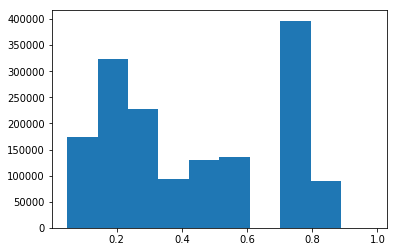

In [37]:
plt.pyplot.hist(preds)

## Running the cells below will take a lot of time

## STOP HERE

In [ ]:
num_round = 10

max_depth_list = [x*10+10 for x in range(3)]
eta_list = [x*0.1+0.1 for x in range(9)]
for max_depth in max_depth_list: 
    for eta in eta_list: 
        param = {'max_depth':max_depth, 'eta':eta, 'silent':0, 'eval_metric':'logloss', 'objective':'binary:logistic' }
        bst = xgb.train(param, dtrain, num_round, verbose_eval=200)
        preds = bst.predict(dtest)
        y_pred = np.array([float(i) for i in np.round(preds)])
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        print("Max depth: " + str(max_depth) + " Eta: " + str(eta) + " Precision: " + str(precision) + " Recall: " + str(recall))